This time we will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990.


In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [2]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data

In [22]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header
        
        for row in reader:
            times.append(len(temperatures))  # Timesteps starting at zero
            temperatures.append(float(row[1]))
            
    return times, temperatures

The next cell will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

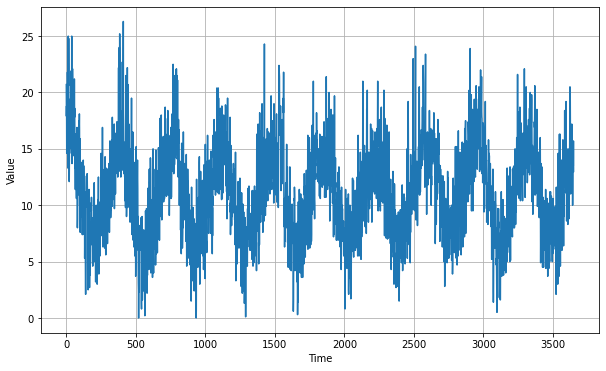

In [23]:

@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data


In [24]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [25]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture


In [28]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                                  strides=1,
                                  activation="relu",
                                  padding='causal',
                                  input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.LSTM(64, return_sequences=True),
          tf.keras.layers.LSTM(64),
          tf.keras.layers.Dense(30, activation="relu"),
          tf.keras.layers.Dense(10, activation="relu"),
          tf.keras.layers.Dense(1),
    ]) 


    return model

In [29]:
# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate 

In [30]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = 'adam'

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [31]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 12s 110ms/step - loss: 8.5240 - mae: 9.0212 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 8s 109ms/step - loss: 4.1534 - mae: 4.6304 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 8s 109ms/step - loss: 2.5669 - mae: 3.0304 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 8s 105ms/step - loss: 1.9288 - mae: 2.3803 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 9s 110ms/step - loss: 1.8288 - mae: 2.2795 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 8s 107ms/step - loss: 1.8040 - mae: 2.2547 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 8s 107ms/step - loss: 1.7546 - mae: 2.2029 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 8s 108ms/step - loss: 1.6947 - mae: 2.1452 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 8s 106ms/step - loss: 1.6741 - mae: 2.1228

(0.0001, 10.0, 0.0, 10.0)

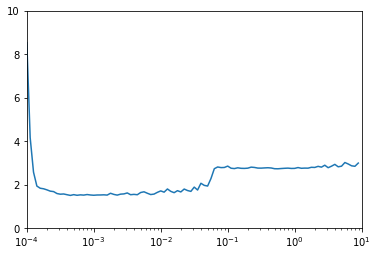

In [32]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Compiling the model

In [33]:
def create_model():

    
    model = create_uncompiled_model()

    learning_rate = 1e-3
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])  

    return model

In [34]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 13s 126ms/step - loss: 4.9412 - mae: 5.4198
Epoch 2/50
77/77 [==============================] - 10s 125ms/step - loss: 2.2657 - mae: 2.7241
Epoch 3/50
77/77 [==============================] - 10s 127ms/step - loss: 1.9720 - mae: 2.4219
Epoch 4/50
77/77 [==============================] - 10s 127ms/step - loss: 1.9077 - mae: 2.3603
Epoch 5/50
77/77 [==============================] - 10s 128ms/step - loss: 1.8008 - mae: 2.2562
Epoch 6/50
77/77 [==============================] - 10s 127ms/step - loss: 1.7619 - mae: 2.2117
Epoch 7/50
77/77 [==============================] - 10s 127ms/step - loss: 1.7027 - mae: 2.1495
Epoch 8/50
77/77 [==============================] - 10s 125ms/step - loss: 1.6285 - mae: 2.0742
Epoch 9/50
77/77 [==============================] - 10s 130ms/step - loss: 1.6002 - mae: 2.0444
Epoch 10/50
77/77 [==============================] - 10s 131ms/step - loss: 1.6831 - mae: 2.1347
Epoch 11/50
77/77 [====================

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast.

In [35]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## Faster model forecasts

In [36]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Now compute the actual forecast:


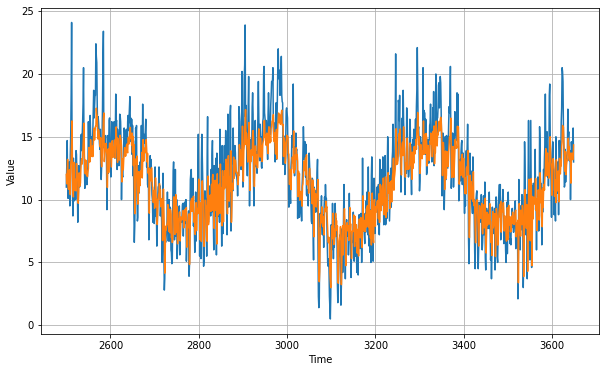

In [37]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [38]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.52, mae: 1.83 for forecast


In [39]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/
